In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import skimage.io as io
import tqdm
from source_functions.main import *
# Main functions: transform_label, find_aligned_label
from source_functions.label_merging import align_merged_label
from source_functions.alignment_helper_functions import combine_masks

In [2]:
pth_to_images1 = '../../ALICE_Data/resized/train'
pth_to_images2 = '../../ALICE_Data/resized/val'
pth_to_masks = 'CNN_Results/sample_tests/samp_masks'

In [3]:
pin_pth = 'CNN_Results/sample_tests/pins/samp_masks'

files = []
files_trim = []
for file in os.listdir(pin_pth):
    files.append(file)
    files_trim.append(file[:-6]+'.JPG')
    
df_pin = pd.DataFrame([files,files_trim]).T

pin_names = np.unique(list(df_pin[1]))

In [9]:
pin_msks

['Tri434007_additional_4_0.npy',
 'Tri434007_additional_4_1.npy',
 'Tri434007_additional_4_2.npy']

In [4]:
all_pin_masks = {}

for nm in tqdm.tqdm(pin_names):
    pin_msks = list(df_pin[df_pin[1]==nm][0])
    
    try:
        img_orig = io.imread(pth_to_images1+'/'+nm)
    except:
        img_orig = io.imread(pth_to_images2+'/'+nm)

    msk_img = deepcopy(img_orig)

    for msk in pin_msks:
        msk_pth = pin_pth+'/'+msk
        mask_pin = np.load(msk_pth)
        msk_img[np.where(mask_pin==True)] = [255,0,0]

    all_pin_masks[nm] = msk_img

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 21.21it/s]


In [5]:
df = pd.read_csv('sample_names.csv')
df['Mask_Path'] = [pth_to_masks+'/'+f for f in df['Mask']]

img_paths = []

for img in df['Image']:
    try:
        img_pth = pth_to_images1+'/'+img
        _ = io.imread(img_pth)
    except:
        img_pth = pth_to_images2+'/'+img
    img_paths.append(img_pth)
    
df['Image_Path'] = img_paths
specimen_sample = np.unique(df['Position_ID'])

In [16]:
label_results1 = {}
label_results2 = {}
label_results3 = {}
label_results4 = {}

errors1 = []
errors2 = []
errors3 = []
errors4 = []


for img_id in tqdm.tqdm(specimen_sample):
    # TEST 1
    try:
        all_images,transformed,merged = find_aligned_label(img_id,df,all_pin_masks,
                    remove_pin=False,template_option=2,ydist=True,align=True,
                    combine_extra_masks = True,template_label=None,merge_method=0,filter_imgs=True)
        
        aligned = align_merged_label(merged)

        label_results1.update({img_id:{"orig" : all_images[0],"transformed":transformed,
                                      "merged":merged,"final" : aligned}})
    except:
        errors1.append(img_id)
    # TEST 2
    try:
        all_images,transformed,merged = find_aligned_label(img_id,df,all_pin_masks,
                    remove_pin=False,template_option=1,ydist=True,align=True,
                    combine_extra_masks = True,template_label=None,merge_method=0,filter_imgs=True)
        
        aligned = align_merged_label(merged)

        label_results2.update({img_id:{"orig" : all_images[0],"transformed":transformed,
                                      "merged":merged,"final" : aligned}})
    except:
        errors2.append(img_id)
    # TEST 3
    try:
        all_images,transformed,merged = find_aligned_label(img_id,df,all_pin_masks,
                    remove_pin=False,template_option=2,ydist=False,align=True,
                    combine_extra_masks = True,template_label=None,merge_method=0,filter_imgs=True)
        
        aligned = align_merged_label(merged)

        label_results3.update({img_id:{"orig" : all_images[0],"transformed":transformed,
                                      "merged":merged,"final" : aligned}})
    except:
        errors3.append(img_id)
    # TEST 4
    try:
        all_images,transformed,merged = find_aligned_label(img_id,df,all_pin_masks,
                    remove_pin=False,template_option=2,ydist=False,align=True,
                    combine_extra_masks = True,template_label=None,merge_method=0,filter_imgs=True)
        
        aligned = align_merged_label(merged)

        label_results4.update({img_id:{"orig" : all_images[0],"transformed":transformed,
                                      "merged":merged,"final" : aligned}})
    except:
        errors4.append(img_id)

100%|███████████████████████████████████████████| 19/19 [06:22<00:00, 20.12s/it]


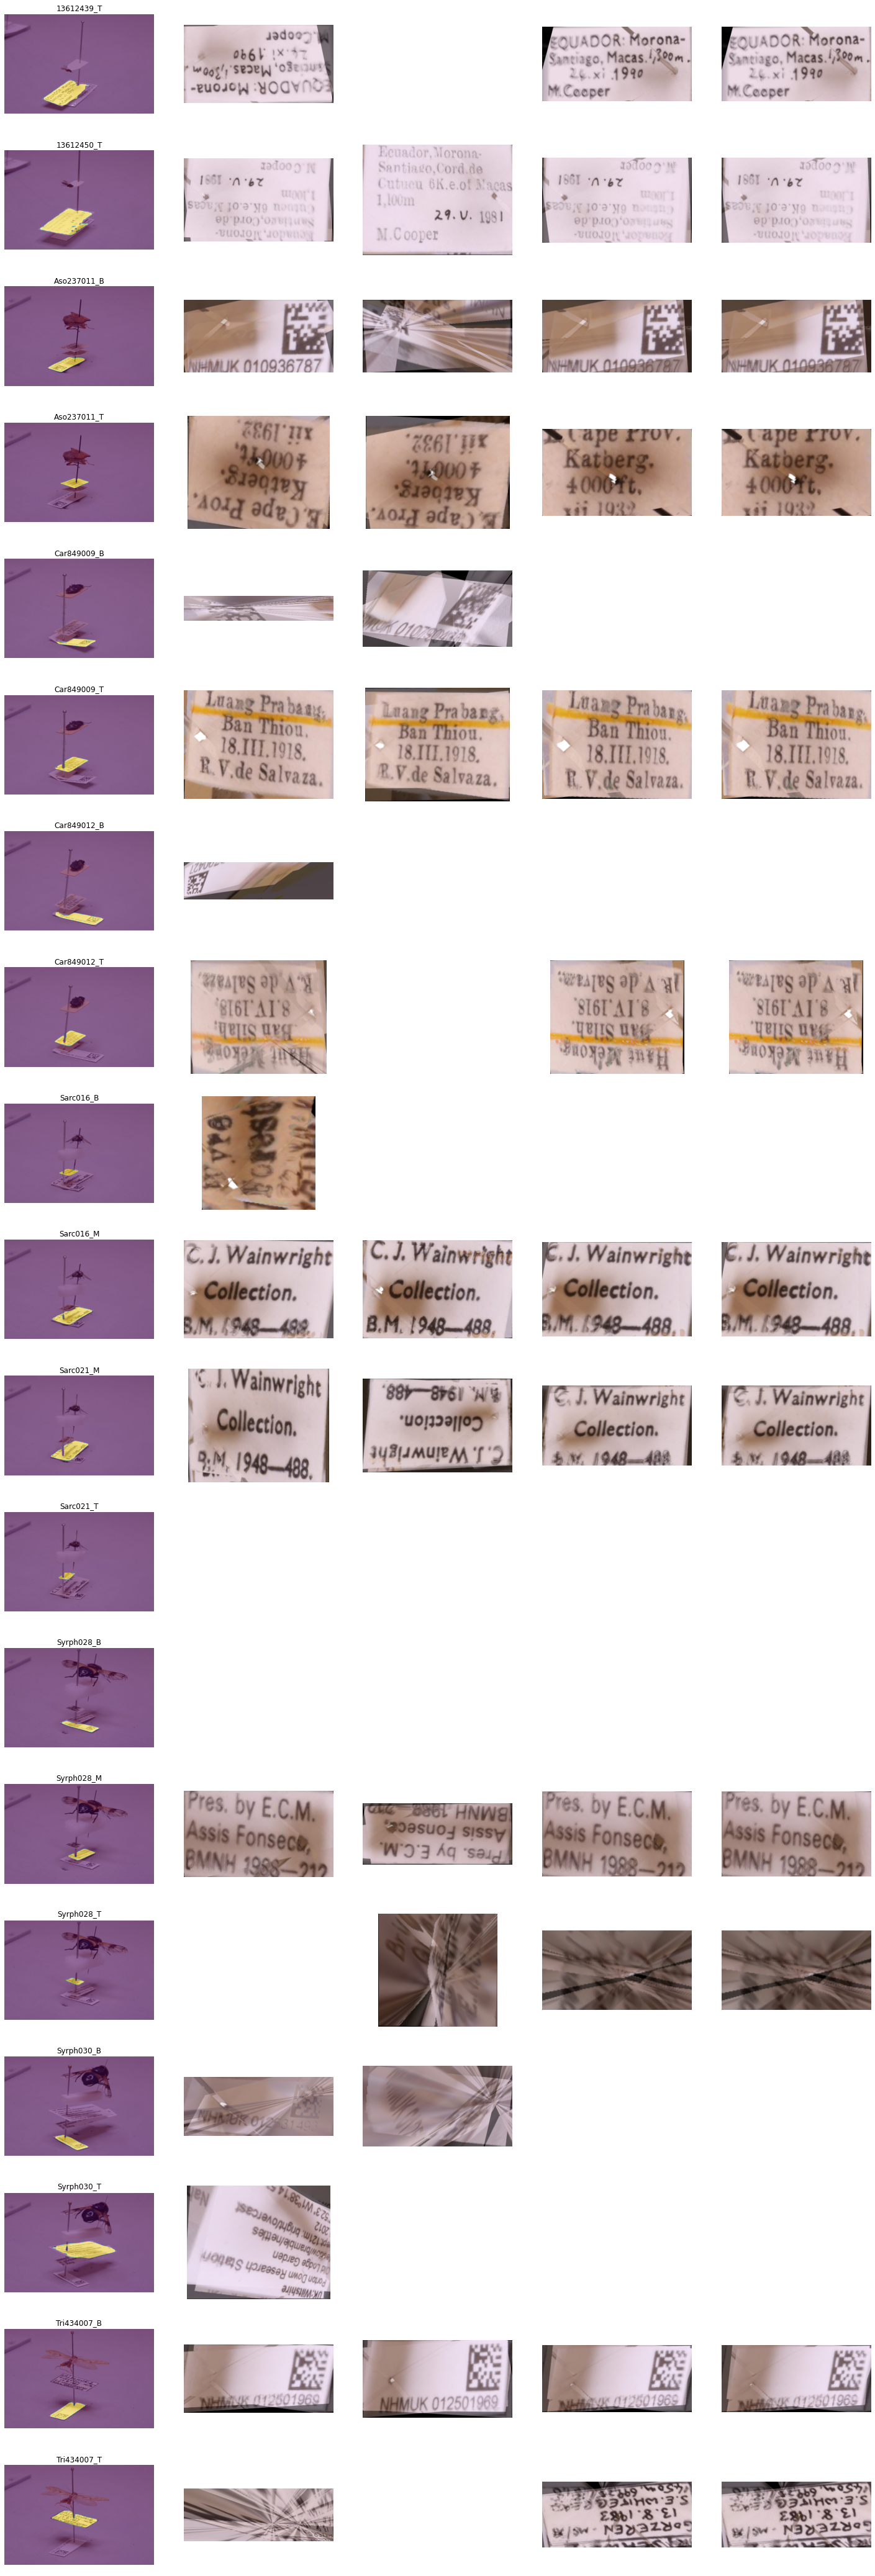

In [15]:
fig,ax = plt.subplots(19,5,figsize=(5*5,4*19))

for i,img_id in enumerate(specimen_sample):
    
    # Plot original image:
    bla = df[df['Position_ID']==img_id].reset_index()
    imgpth = bla['Image_Path'].iloc[0]
    mskpth = bla['Mask_Path'].iloc[0]
    img = io.imread(imgpth)
    msk = np.load(mskpth)
    ax[i,0].imshow(img)
    ax[i,0].imshow(msk,alpha=0.5)
    ax[i,0].set_title(img_id)
    
    # Aligned Image #1
    if img_id not in errors1:
        ax[i,1].imshow(label_results1[img_id]["final"])
        
    # Aligned Image #2
    if img_id not in errors2:
        ax[i,2].imshow(label_results2[img_id]["final"])
        
    # Aligned Image #3
    if img_id not in errors3:
        ax[i,3].imshow(label_results3[img_id]["final"])
        
    # Aligned Image #4
    if img_id not in errors4:
        ax[i,4].imshow(label_results4[img_id]["final"])
        
    for j in range(0,5):
        ax[i,j].axis('off')
        
plt.savefig('label_tests.pdf',dpi=600,bbox_inches='tight',pad_inches=0.15)

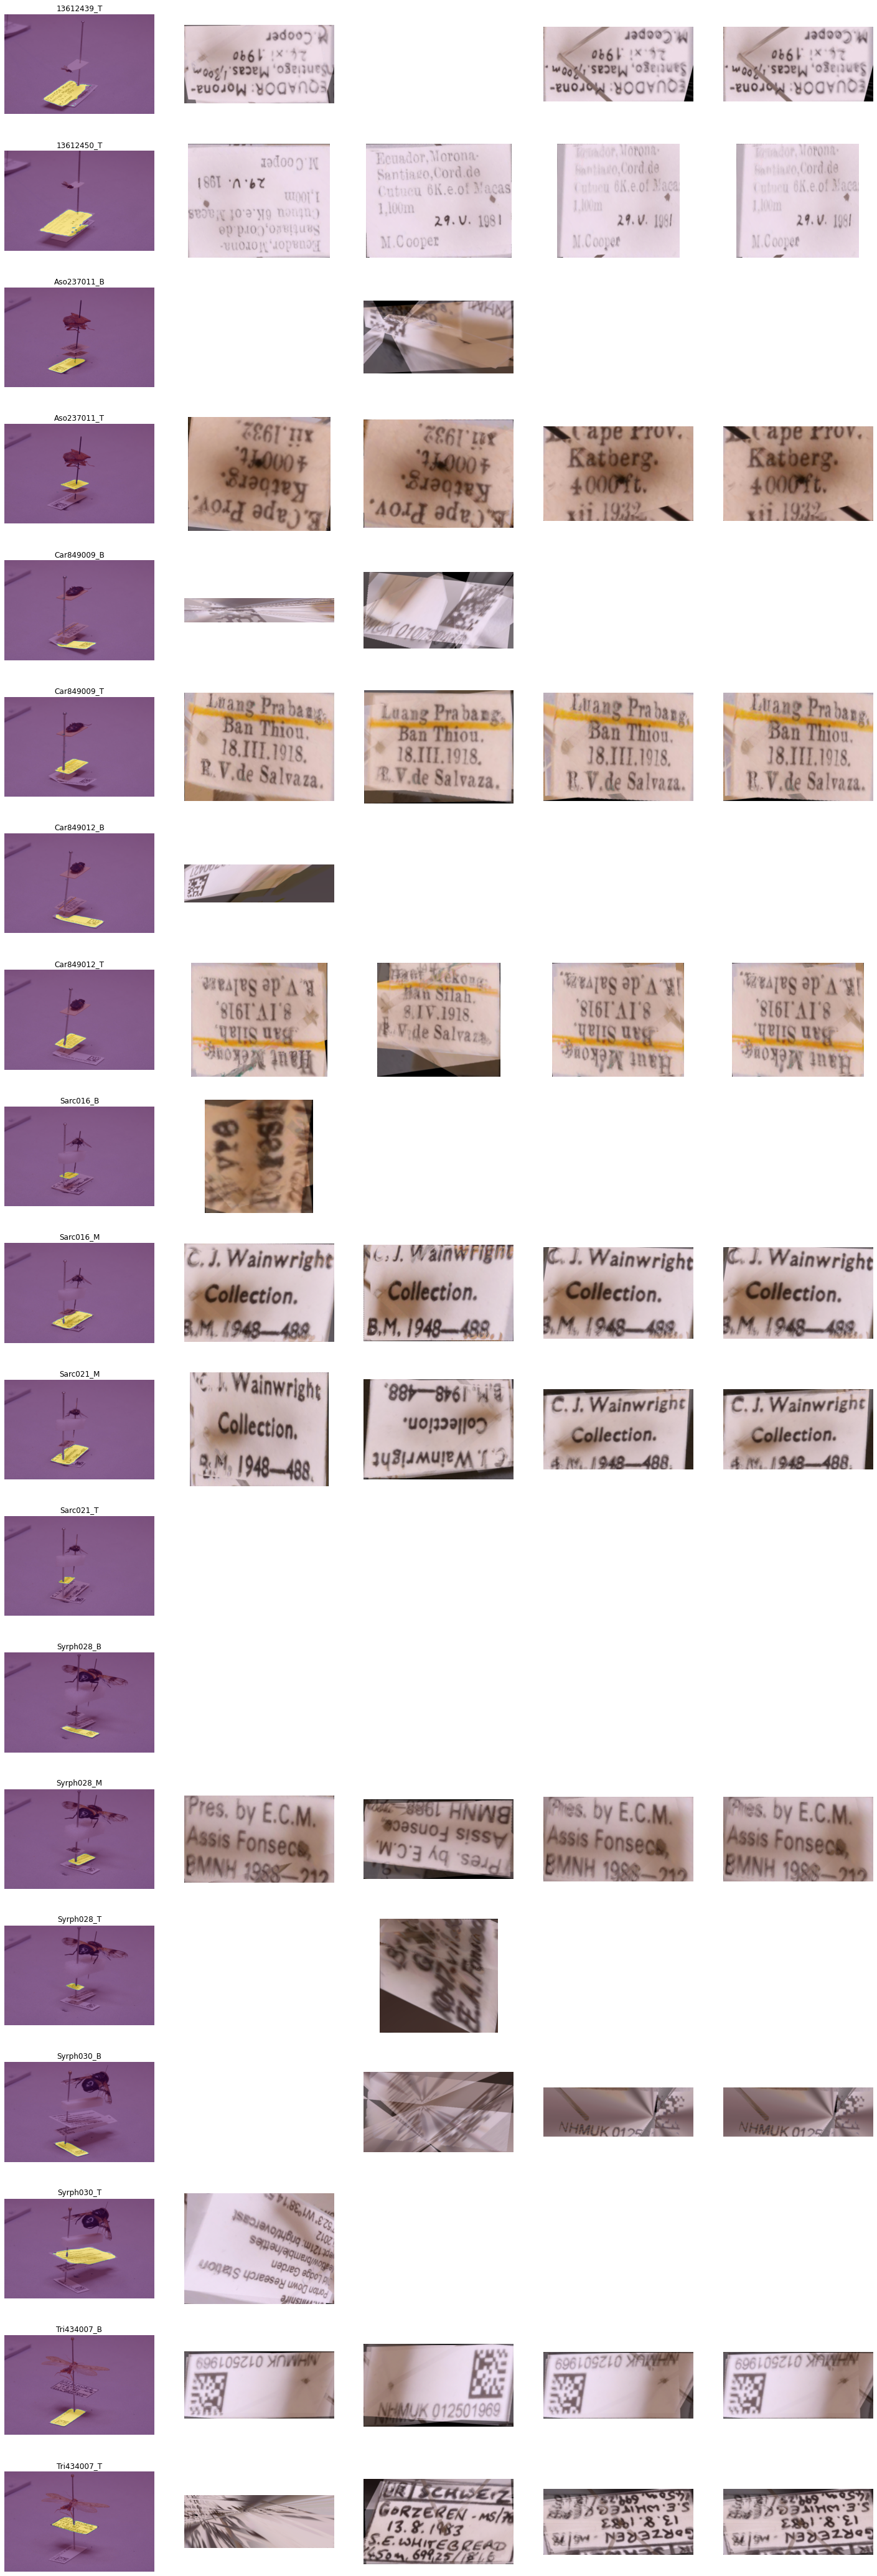

In [18]:
fig,ax = plt.subplots(19,5,figsize=(5*5,4*19))

for i,img_id in enumerate(specimen_sample):
    
    # Plot original image:
    bla = df[df['Position_ID']==img_id].reset_index()
    imgpth = bla['Image_Path'].iloc[0]
    mskpth = bla['Mask_Path'].iloc[0]
    img = io.imread(imgpth)
    msk = np.load(mskpth)
    ax[i,0].imshow(img)
    ax[i,0].imshow(msk,alpha=0.5)
    ax[i,0].set_title(img_id)
    
    # Aligned Image #1
    if img_id not in errors1:
        ax[i,1].imshow(label_results1[img_id]["final"])
        
    # Aligned Image #2
    if img_id not in errors2:
        ax[i,2].imshow(label_results2[img_id]["final"])
        
    # Aligned Image #3
    if img_id not in errors3:
        ax[i,3].imshow(label_results3[img_id]["final"])
        
    # Aligned Image #4
    if img_id not in errors4:
        ax[i,4].imshow(label_results4[img_id]["final"])
        
    for j in range(0,5):
        ax[i,j].axis('off')
        
plt.savefig('label_tests_withpin.pdf',dpi=600,bbox_inches='tight',pad_inches=0.15)

In [22]:
for img_id in specimen_sample:
    if (img_id in errors1) and (img_id in errors2) and (img_id in errors3) and (img_id in errors4):
        print(img_id)

Sarc021_T
Syrph028_B


In [27]:
samp = list(label_results1.keys())

In [31]:
im = label_results1[samp[0]]["final"]
print(len(pytesseract.image_to_string(bin_image(im), config='script=Latin')))

3


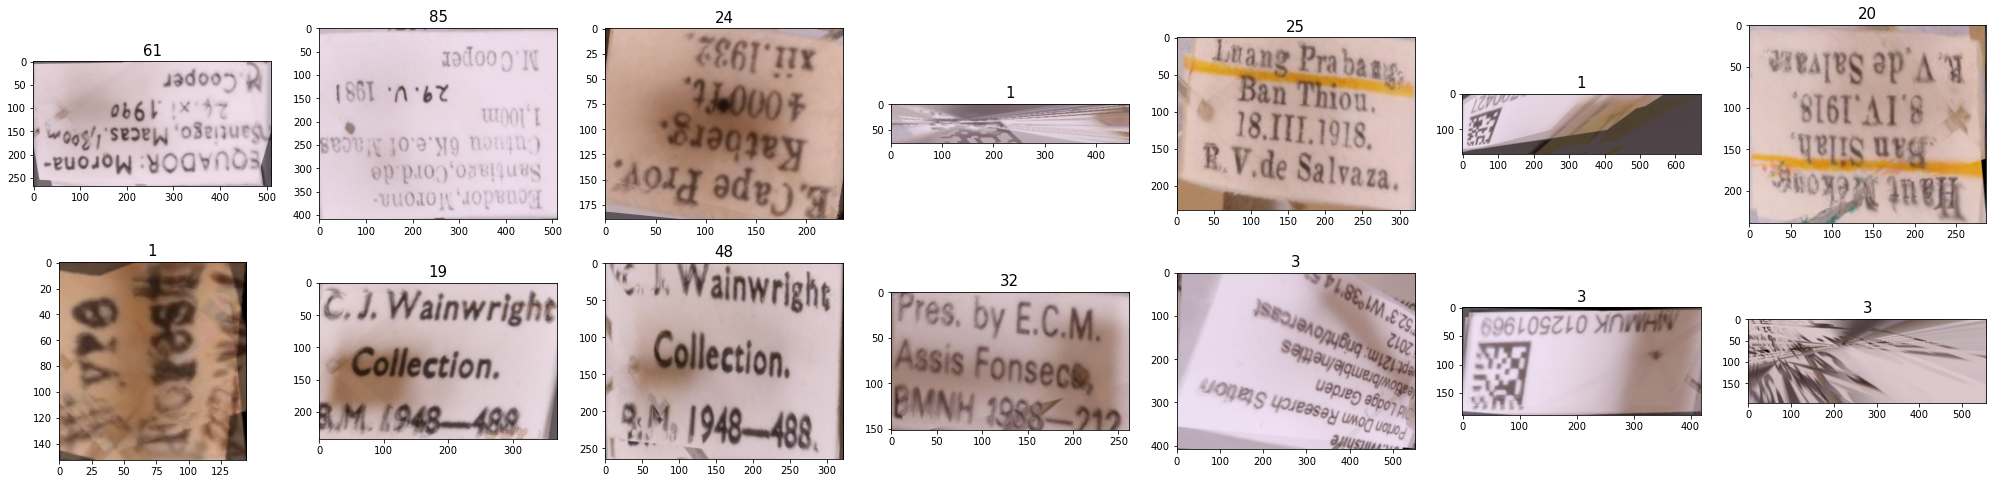

In [35]:
fig,ax = plt.subplots(2,7,figsize=(5*7,4*2))

v = 0

for i,nm in enumerate(samp):
    if (i!=0) and (i%7 == 0):
        v = v+1
    im = label_results1[nm]["final"]
    ax[v,i%7].imshow(im)
    h = len(pytesseract.image_to_string(im, config='script=Latin'))
    ax[v,i%7].set_title(str(h),fontsize=15)

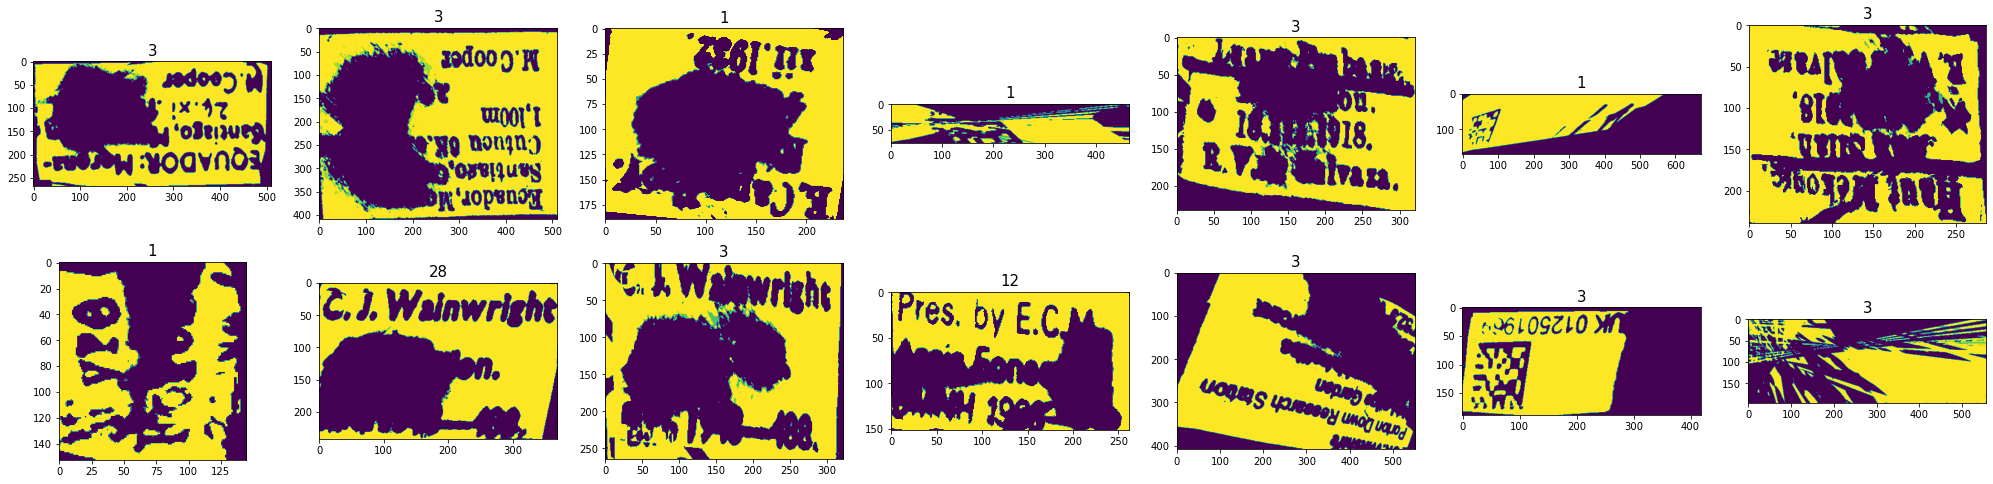

In [34]:
fig,ax = plt.subplots(2,7,figsize=(5*7,4*2))

v = 0

for i,nm in enumerate(samp):
    if (i!=0) and (i%7 == 0):
        v = v+1
    im = label_results1[nm]["final"]
    ax[v,i%7].imshow(bin_image(im))
    h = len(pytesseract.image_to_string(bin_image(im), config='script=Latin'))
    osd = pytesseract.image_to_osd(bin_image(im), config='script=Latin')
    
    ax[v,i%7].set_title(str(h),fontsize=15)

In [7]:
msk = all_pin_masks['013612439_additional_1.JPG']

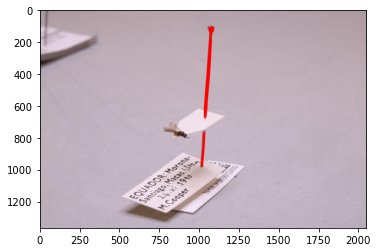

In [8]:
fig,ax = plt.subplots()
ax.imshow(msk)